In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import featureman.gen_data as man
from sklearn.cluster import SpectralClustering
import pickle
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### what to do next
- decoder/dict_atoms -> sae_hidden x mlp_dim
- relu_acts -> sae_hidden
- out -> mlp_dim

- concat(samples X filtered_sae_hidden) x mlp_dim
- einop('s f m -> (s f) m')
- PCA of that stuff

In [2]:
sae_dict = torch.load("sae_model.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
sae.load_state_dict(sae_dict)

model_dict = torch.load("modular_arithmetic_model.pth", map_location=device)
model = man.OneLayerTransformer(p=113, d_model=128, nheads=4).to(device)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [3]:
torch.manual_seed(1337)
# generate combination of all inputs a and b range (113)
a = np.arange(113)
b = np.arange(113)
# generate inputs for the model
inputs = np.array([[a_i, 113, b_i, 114] for a_i in a for b_i in b])
inputs = torch.tensor(inputs).to(device)  # Add batch dimension
print(inputs.shape)
logits, activations = model(inputs, return_activations=True)
activations_data = activations[:, -1, :].detach()
batched_acts = activations_data.unsqueeze(0).repeat(5, 1, 1).to(device)
del model, model_dict
print(batched_acts.shape)

torch.Size([12769, 4])
torch.Size([5, 12769, 512])


In [4]:
# 0 if modulo 113 > =0 else 1
results = ((inputs[:, 0] + inputs[:, 2]) > 113).detach().cpu().numpy().astype(int)

results.shape

(12769,)

In [5]:
import pickle

decoder = sae.W_d[3].detach()
print(decoder.shape)
_, _, feat_acts, _ = sae(batched_acts)
features = feat_acts[3].detach()
with open("sae_clusters_15.pkl", "rb") as f:
    clusters = pickle.load(f)
clusters = [c for c in clusters if len(c) > 1]  # Filter out clusters with only one element
clusters = sorted(clusters, key=lambda x: len(x), reverse=True)  # Sort by size
print(features.shape)


torch.Size([2048, 512])
torch.Size([12769, 2048])


In [6]:
colors_b = inputs[:, 2].detach().cpu().numpy()

/home/omar-ayyub/p/FeatureManifolds/.venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:787: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


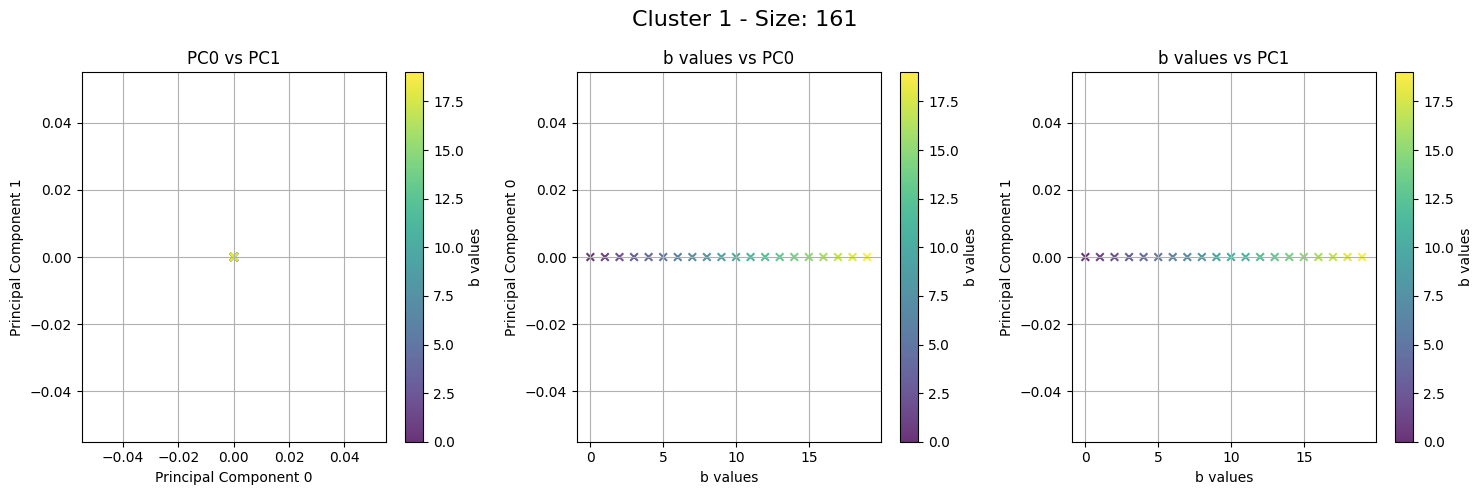

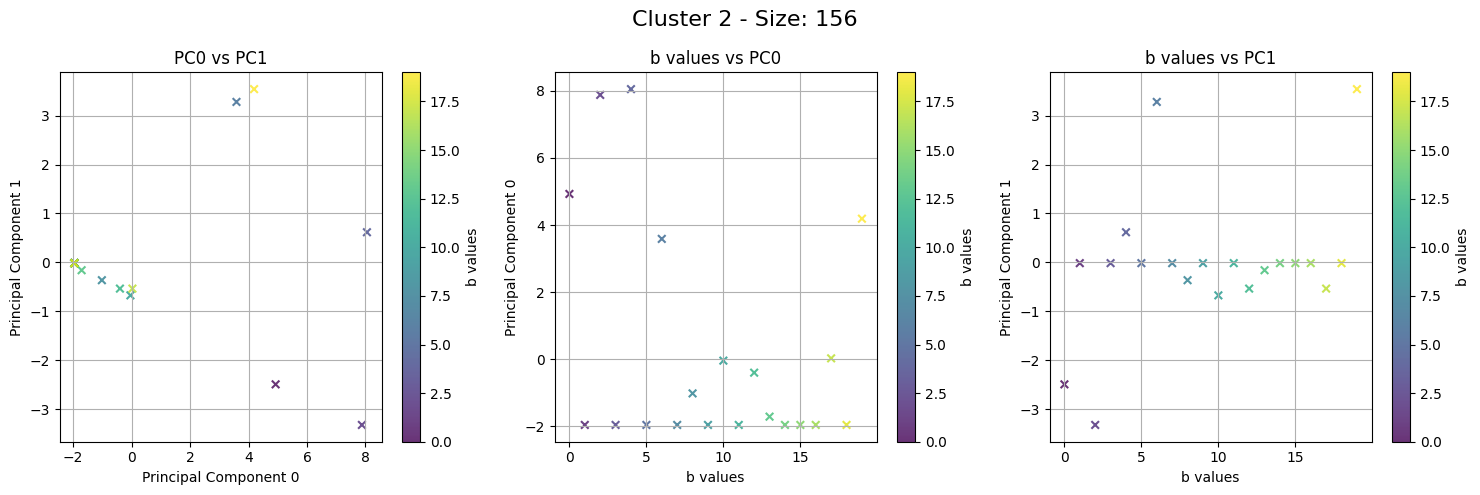

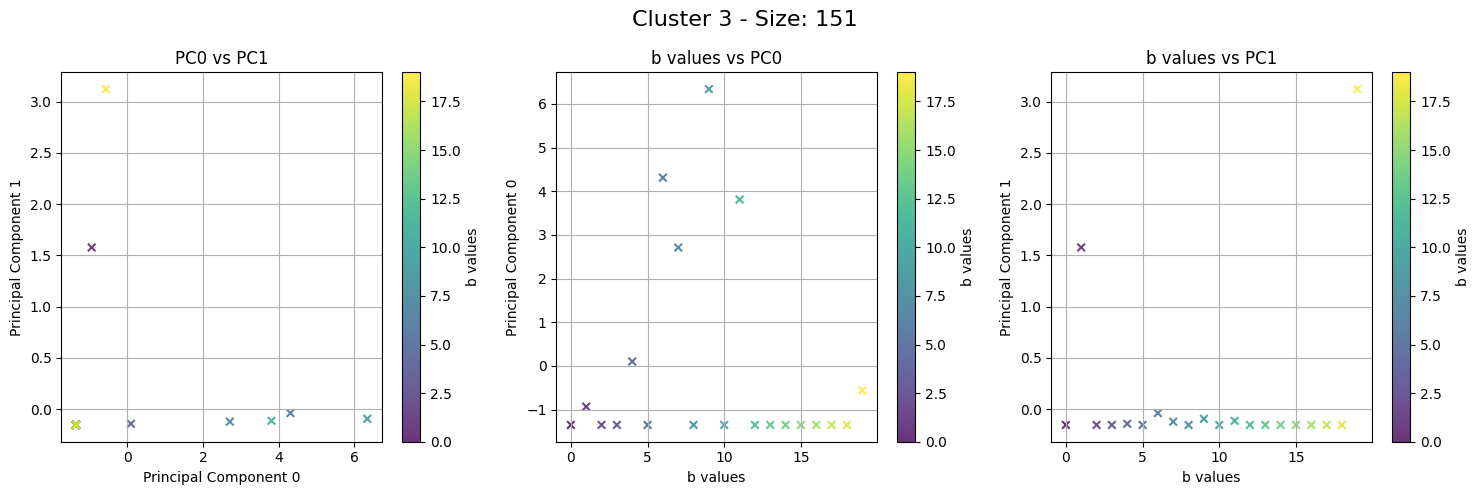

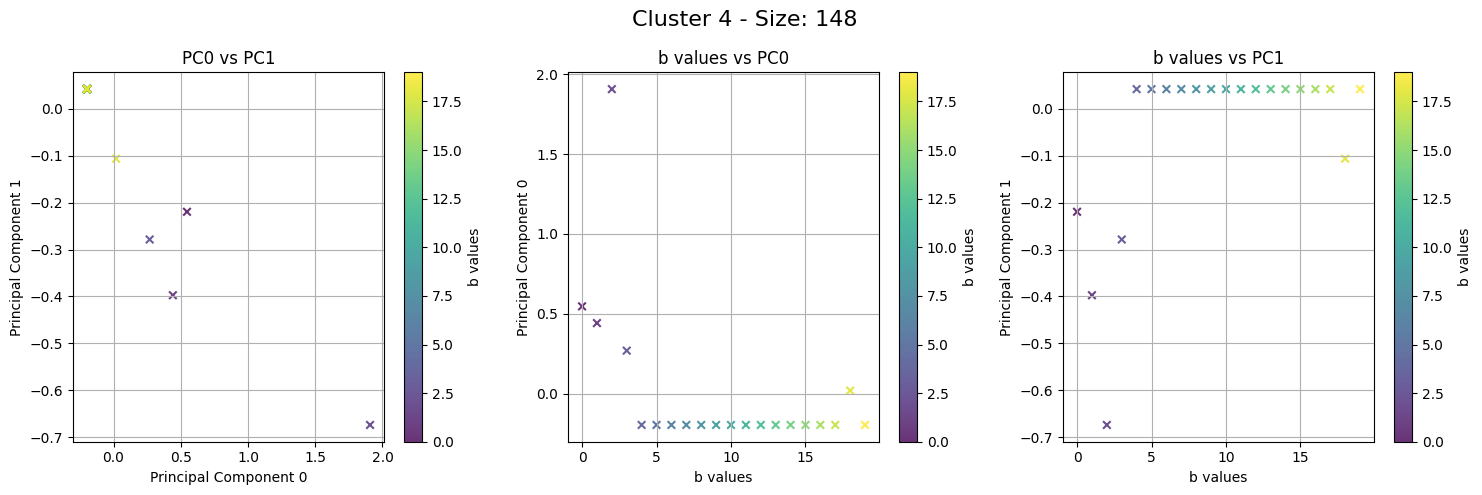

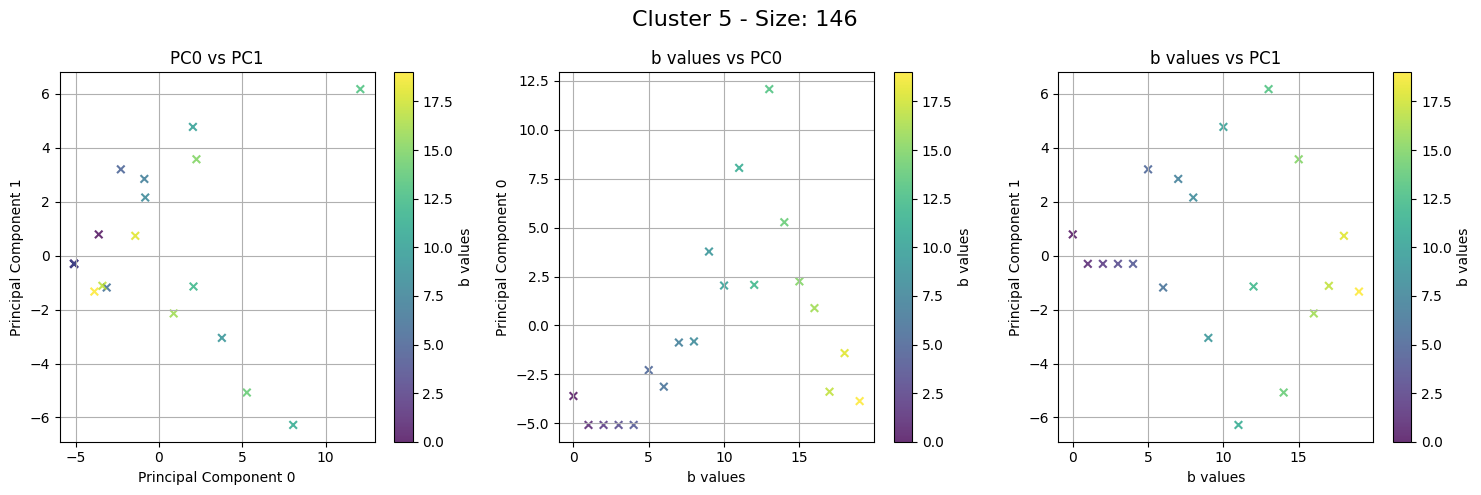

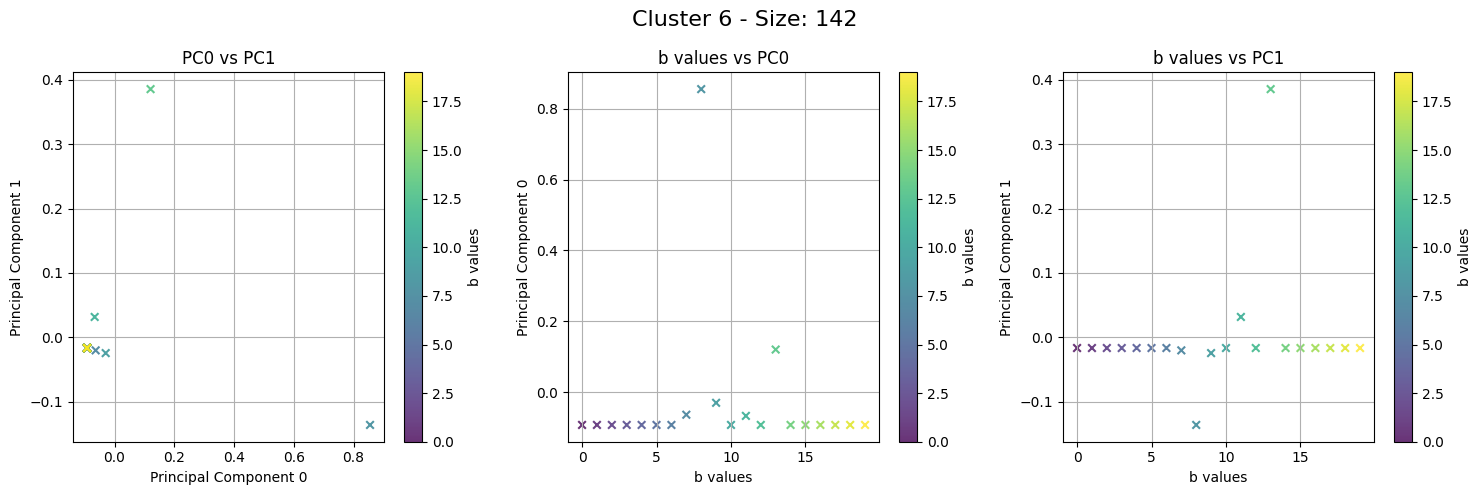

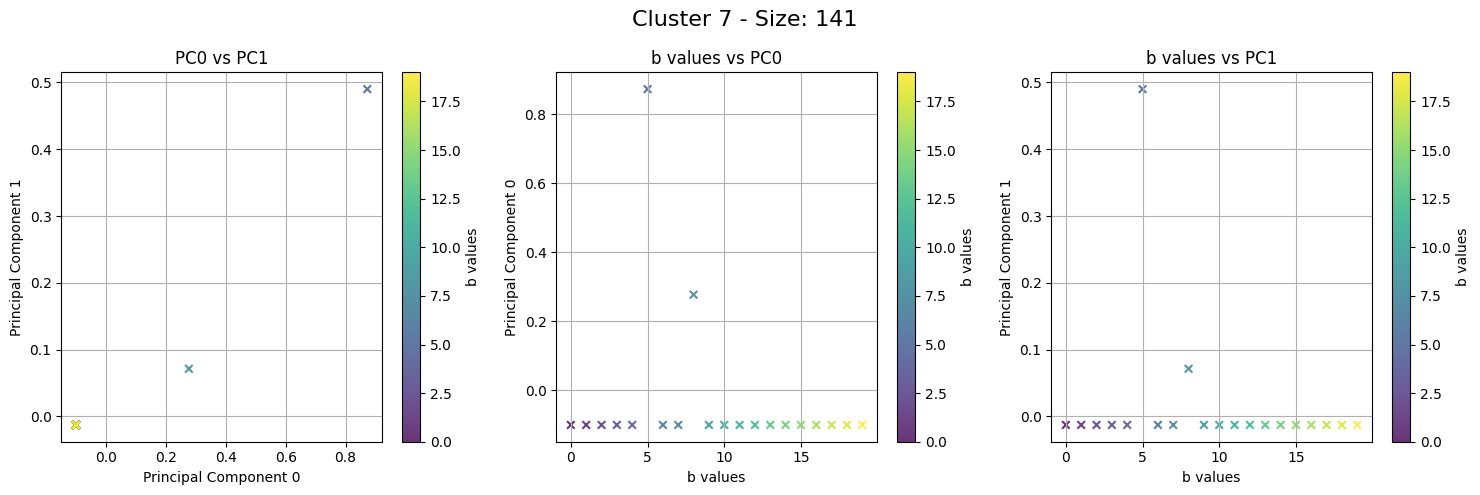

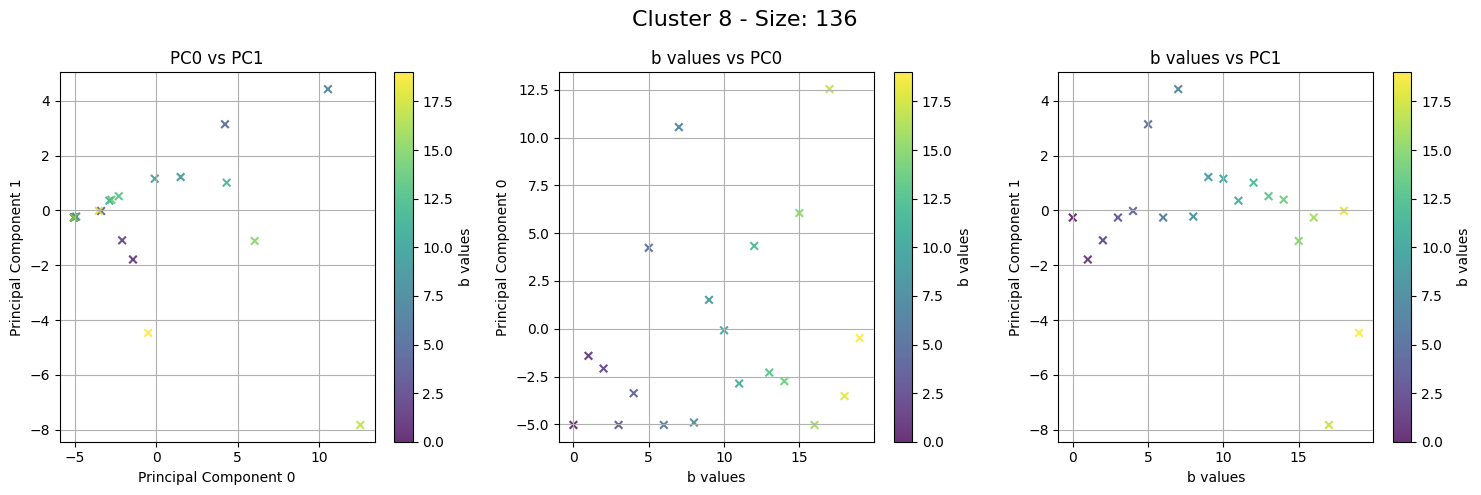

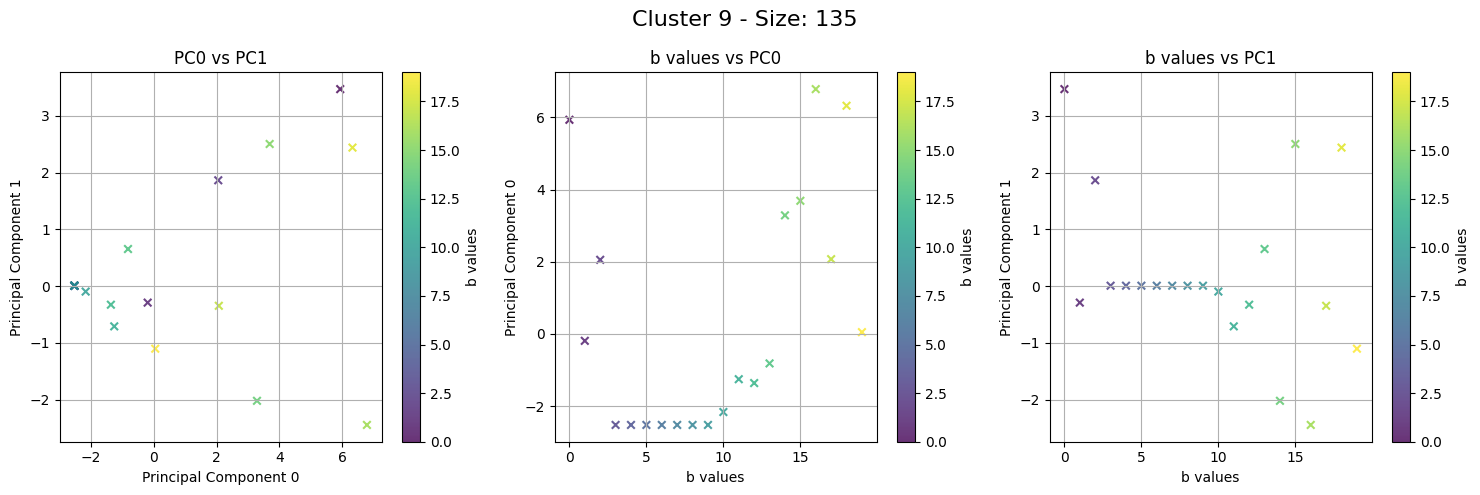

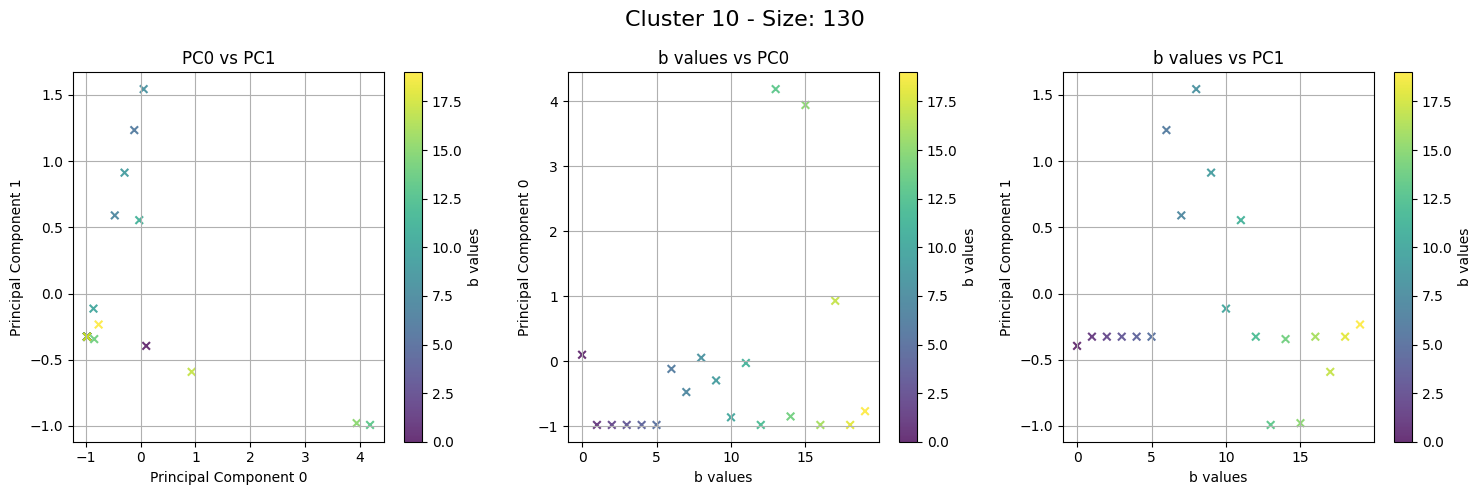

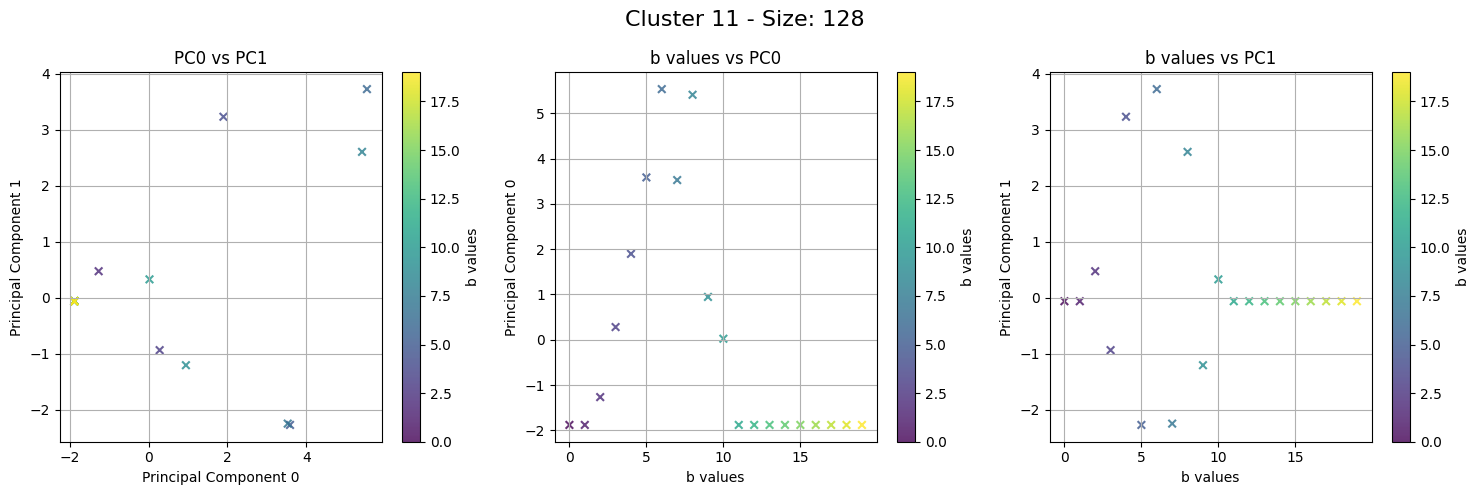

/home/omar-ayyub/p/FeatureManifolds/.venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:787: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


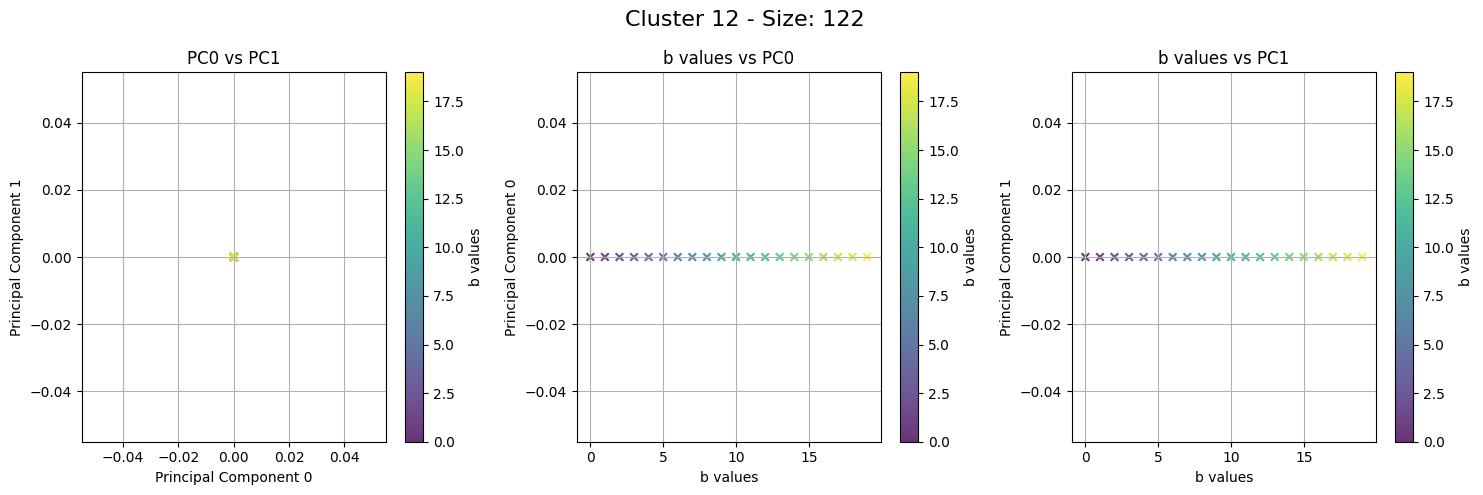

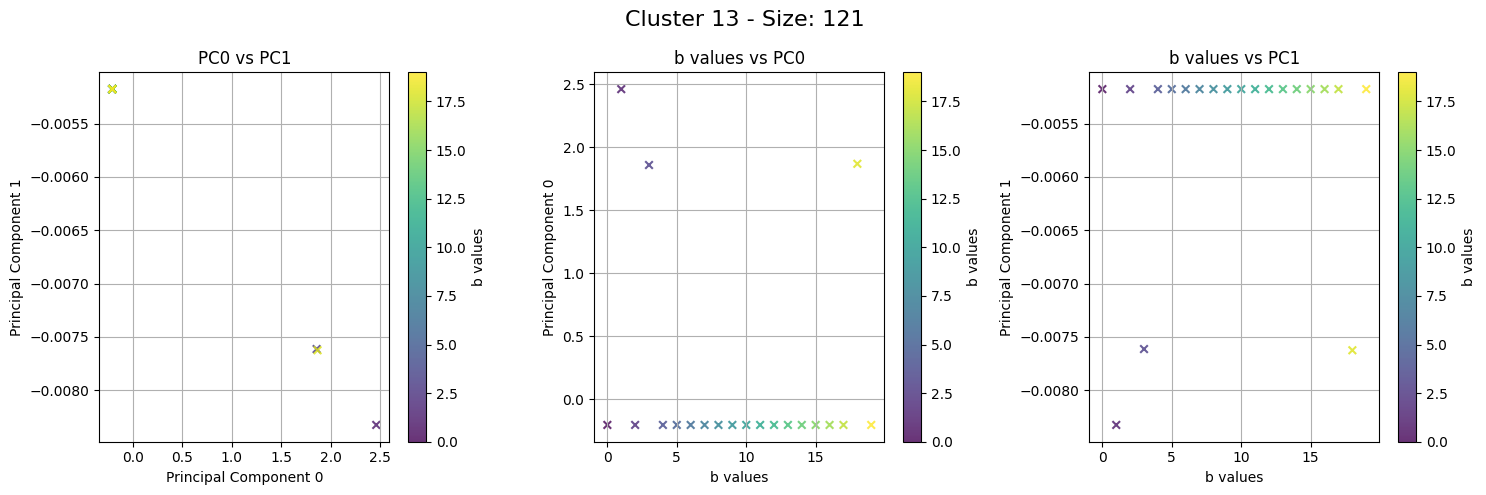

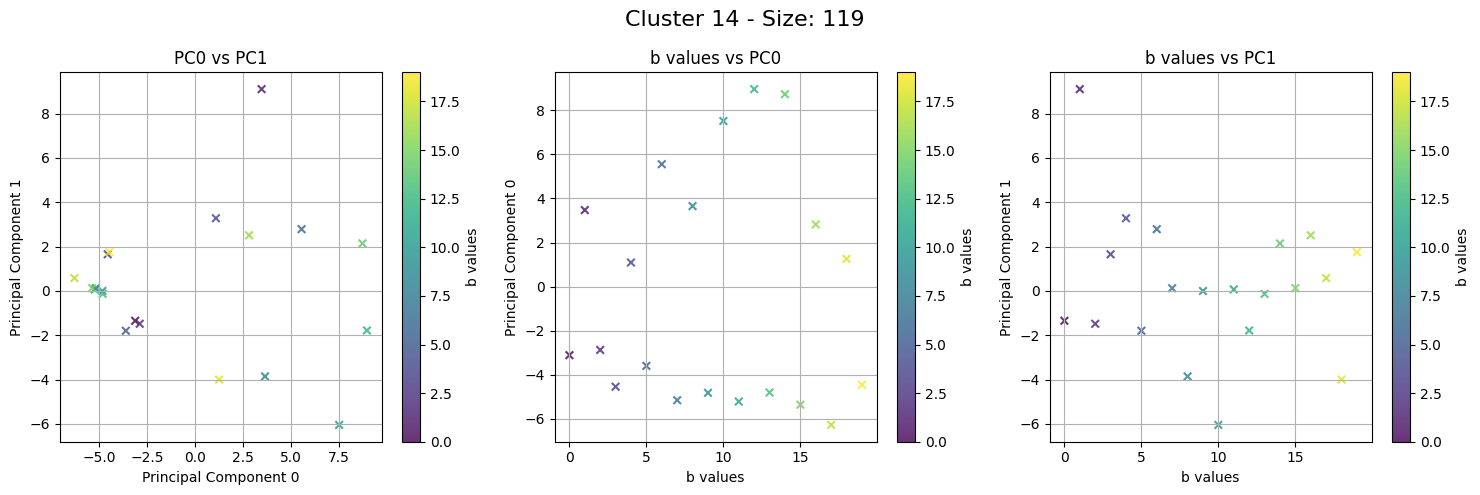

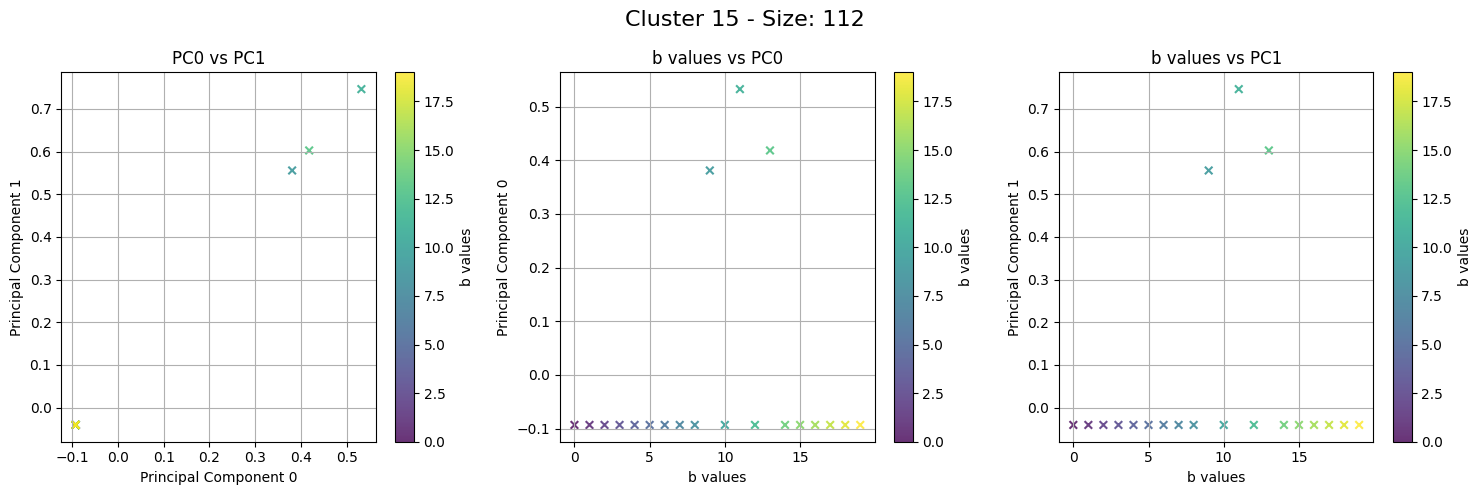

In [49]:
fixed_a = 12
mlp_a_fixed = batched_acts[3][fixed_a*113:fixed_a*113+113].detach().cpu().numpy()

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

for i in range(len(clusters)):
    features_interest = features[:, clusters[i]]
    decoder_interest = decoder[clusters[i], :]
    reconstructions = features_interest @ decoder_interest
    recon_a = reconstructions[fixed_a*113:fixed_a*113+113].detach().cpu().numpy()

    pca = PCA(n_components=2).fit(recon_a)
    output_pca = pca.transform(recon_a)


    plt.figure(figsize=(15, 5))

    # Subplot 1: PC0 vs PC1
    plt.subplot(1, 3, 1)
    scatter1 = plt.scatter(output_pca[:, 0][:20], output_pca[:, 1][:20], marker='x', c=b[:20], s=30, alpha=0.8, cmap='viridis')
    plt.title("PC0 vs PC1")
    plt.xlabel("Principal Component 0")
    plt.ylabel("Principal Component 1")
    plt.grid()
    plt.colorbar(scatter1, label='b values')

    plt.subplot(1, 3, 2)
    scatter2 = plt.scatter(b[:20], output_pca[:, 0][:20], marker='x', c=b[:20], s=30, alpha=0.8, cmap='viridis')
    plt.title("b values vs PC0")
    plt.xlabel("b values")
    plt.ylabel("Principal Component 0")
    plt.grid()
    plt.colorbar(scatter2, label='b values')

    plt.subplot(1, 3, 3)
    scatter3 = plt.scatter(b[:20], output_pca[:, 1][:20], marker='x', c=b[:20], s=30, alpha=0.8, cmap='viridis')
    plt.title("b values vs PC1")
    plt.xlabel("b values")
    plt.ylabel("Principal Component 1")
    plt.grid()
    plt.colorbar(scatter3, label='b values')
    #sup title
    plt.suptitle(f"Cluster {i + 1} - Size: {len(clusters[i])}", fontsize=16)

    plt.tight_layout()
    plt.show()